In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.datasets import mnist
from keras.layers import (Activation,
                          #BatchNormalization,
                          Concatenate, Dense,
                          Embedding, Flatten, Input, Multiply, Reshape)
from keras.layers import LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import utils

from sklearn.preprocessing import LabelEncoder
import cv2 # Import OpenCV

In [2]:
#from keras.layers import BatchNormalization
from tensorflow.compat.v1.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow import keras

import os

from sklearn import preprocessing

In [3]:
import random

seed = 42

# Python's built-in random library
random.seed(seed)

# Scikit-learn (only affects some parts of scikit-learn)
from sklearn.utils import check_random_state
check_random_state(seed)

np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

## Cornell dataset

In [4]:
img_rows = 168
img_cols = 168
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

In [5]:
# Set path for data source
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Load Diffusion/dataset/")

Mounted at /content/gdrive


In [6]:
# Set the path to the folder containing saved files
load_path = "./preprocessed_data_168x168_2years"

# Load saved NumPy arrays
X_train = np.load(os.path.join(load_path, 'X_train.npy'))
X_test = np.load(os.path.join(load_path, 'X_test.npy'))
y_train = np.load(os.path.join(load_path, 'y_train.npy'))
y_test = np.load(os.path.join(load_path, 'y_test.npy'))

# Load saved Pandas DataFrames
train_data = pd.read_pickle(os.path.join(load_path, 'train_data.pkl'))
test_data = pd.read_pickle(os.path.join(load_path, 'test_data.pkl'))
metadata = pd.read_pickle(os.path.join(load_path, 'metadata.pkl'))
metadata_original = pd.read_pickle(os.path.join(load_path, 'metadata_original.pkl'))

In [7]:
def merge_dummified_columns(df, dummified_columns, new_column_name):
    """
    Merges dummified columns into a single column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the dummified columns.
        dummified_columns (list): A list of the names of the dummified columns.
        new_column_name (str): The name of the new column to create.

    Returns:
        pd.DataFrame: The DataFrame with the dummified columns merged into a single new column.
    """
    # Create a new column containing the column name where the value is 1 for each row
    df[new_column_name] = df[dummified_columns].idxmax(axis=1)

    # Drop the dummified columns
    df.drop(dummified_columns, axis=1, inplace=True)

    return df

test_metadata = metadata_original.loc[test_data.columns]

test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['chilledwater', 'electricity', 'gas', 'hotwater', 'steam'],
                     new_column_name='meter_type')
test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['Education', 'Entertainment/public assembly', 'Lodging/residential', 'Office', 'Public services'],
                     new_column_name='building_type')

test_metadata


,lat,lng,year,meter_type,building_type
electricity_Lamb_office_Caitlin_2016,51.497838,-3.186246,2016,electricity,Office
electricity_Rat_public_Kelle_2016,38.903504,-77.005349,2016,electricity,Public services
electricity_Rat_assembly_Ezequiel_2016,38.903504,-77.005349,2016,electricity,Entertainment/public assembly
electricity_Bear_assembly_Roxy_2016,37.871903,-122.260729,2016,electricity,Entertainment/public assembly
gas_Shrew_office_Rose_2017,51.499840,-0.124663,2017,gas,Office
...,...,...,...,...,...
steam_Moose_education_Omar_2016,45.421500,-75.697200,2016,steam,Education
electricity_Rat_public_Chrissy_2017,38.903504,-77.005349,2017,electricity,Public services
electricity_Hog_office_Merilyn_2016,44.978782,-93.255398,2016,electricity,Office
steam_Bull_assembly_Amalia_2016,30.267200,-97.743100,2016,steam,Entertainment/public assembly


In [8]:

X_train.shape

(2702, 168, 168, 1)

In [9]:
X_test.shape

(901, 168, 168, 1)

In [10]:
y_train.shape

(2702, 13)

In [11]:
y_test.shape

(901, 13)

In [12]:
metadata_test = metadata.loc[test_data.columns]

In [13]:
# Dims of meta
dims_meta = y_test.shape[1]
dims_meta

13

In [14]:
print(X_train.max())
print(X_train.min())

1.0
-1.0


## Generator

In [ ]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 13x42x256 tensor via a fully connected layer
    model.add(Dense(256 * int(img_rows/4) * int(img_cols/4), input_dim=z_dim))
    model.add(Reshape((int(img_rows/4), int(img_cols/4), 256)))

    # Transposed convolution layer, from 13x42x256 into 26x84x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 26x84x128 to 26x84x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 26x84x64 to 52x168x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

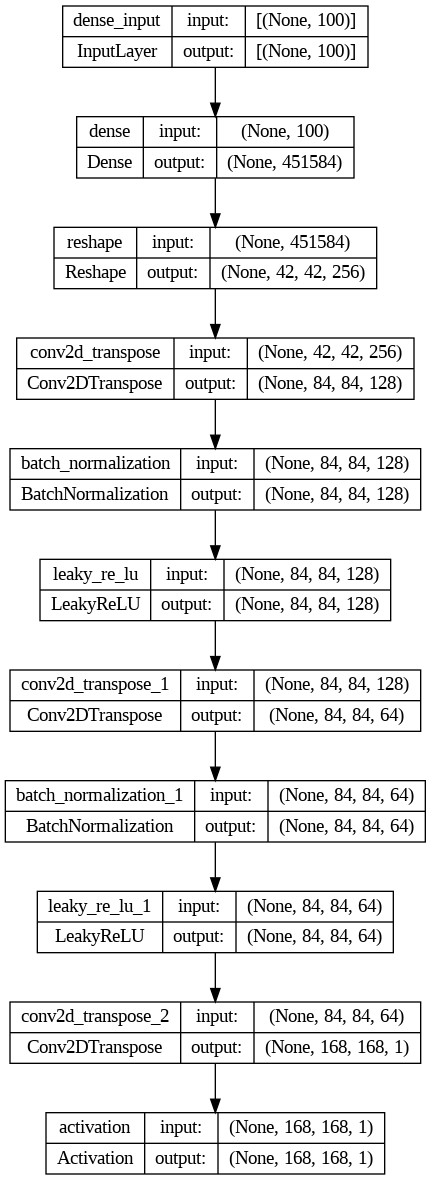

In [ ]:
utils.plot_model(build_generator(z_dim), show_shapes=True)

In [ ]:
def build_cgan_generator(z_dim):

    # Random noise vector z
    z = Input(shape=(z_dim, ))

    # Conditioning label: integer 0-9 specifying the number G should generate
    label = Input(shape=(dims_meta, ), dtype='float')

    # Label embedding:
    # ----------------
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape (batch_size, 1, z_dim)
    #label_embedding = Embedding(num_classes, z_dim, input_length=3)(label)

    # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, z_dim)
    label_embedding = Dense(z_dim)(label)

    # Element-wise product of the vectors z and the label embeddings
    joined_representation = Multiply()([z, label_embedding])

    generator = build_generator(z_dim)

    # Generate image for the given label
    conditioned_img = generator(joined_representation)

    return Model([z, label], conditioned_img)

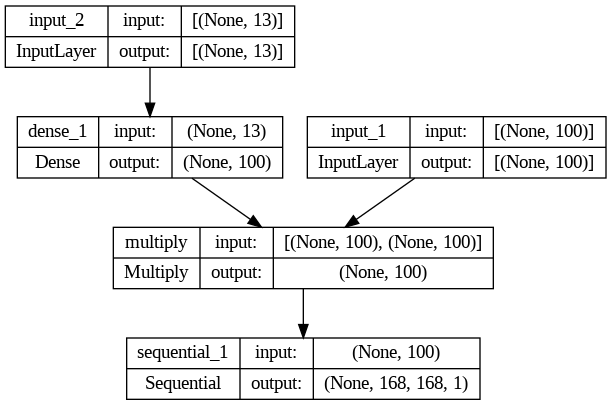

In [ ]:
utils.plot_model(build_cgan_generator(z_dim), show_shapes=True)

## Discriminator

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 52x168x2 into 26x84x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 26x84x64 into 13x42x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 13x42x64 tensor into 7x21x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=(2, 2),
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

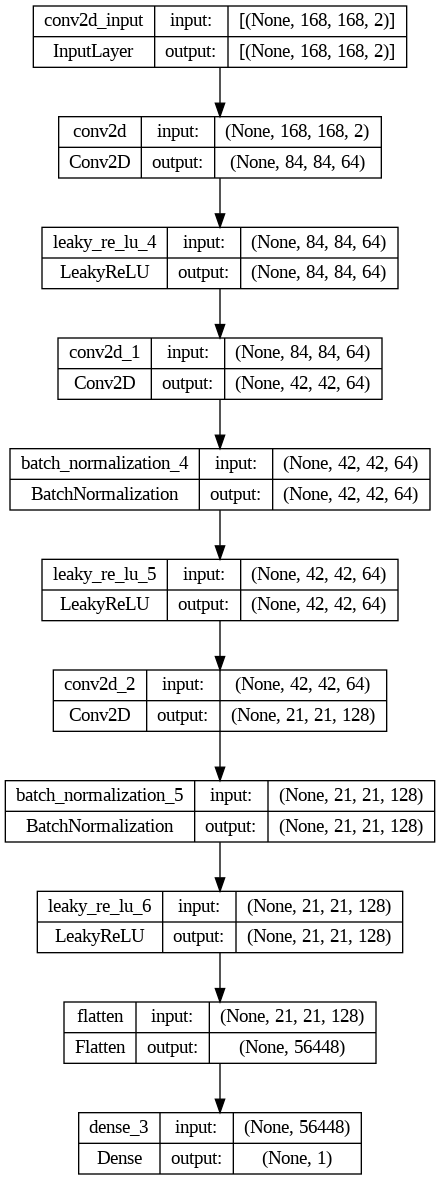

In [ ]:
utils.plot_model(build_discriminator(img_shape), show_shapes=True)

In [ ]:
def build_cgan_discriminator(img_shape):

    # Input image
    img = Input(shape=img_shape)

    # Label for the input image
    label = Input(shape=(dims_meta, ), dtype='float')

    # Label embedding:
    # ----------------
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape (batch_size, 1, 28*28*1)
    #label_embedding = Embedding(num_classes,
    #                            np.prod(img_shape),
    #                            input_length=3)(label)

    # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, 28*28*1)
    label_embedding = Dense(np.prod(img_shape))(label)

    # Reshape label embeddings to have same dimensions as input images
    label_embedding = Reshape(img_shape)(label_embedding)

    # Concatenate images with their label embeddings
    concatenated = Concatenate(axis=-1)([img, label_embedding])

    discriminator = build_discriminator(img_shape)

    # Classify the image-label pair
    classification = discriminator(concatenated)

    return Model([img, label], classification)

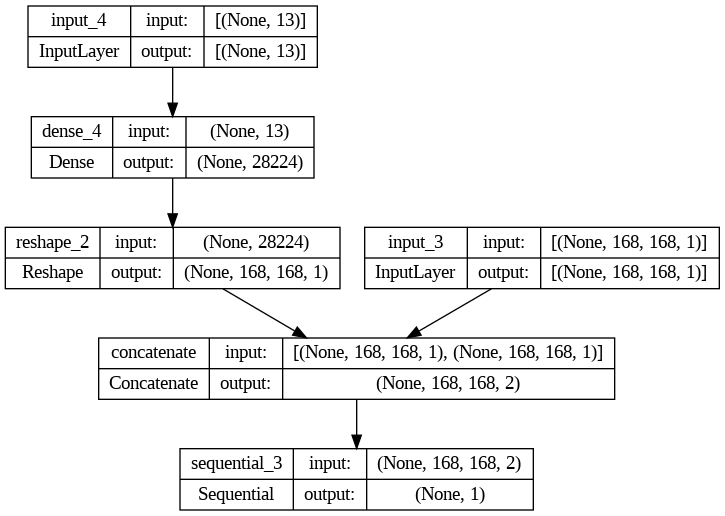

In [ ]:
utils.plot_model(build_cgan_discriminator(img_shape), show_shapes=True)

## Build the Model

In [ ]:
def build_cgan(generator, discriminator):

    # Random noise vector z
    z = Input(shape=(z_dim, ))

    # Image label
    label = Input(shape=(dims_meta, ))

    # Generated image for that label
    img = generator([z, label])

    classification = discriminator([img, label])

    # Combined Generator -> Discriminator model
    # G([z, lablel]) = x*
    # D(x*) = classification
    model = Model([z, label], classification)

    return model

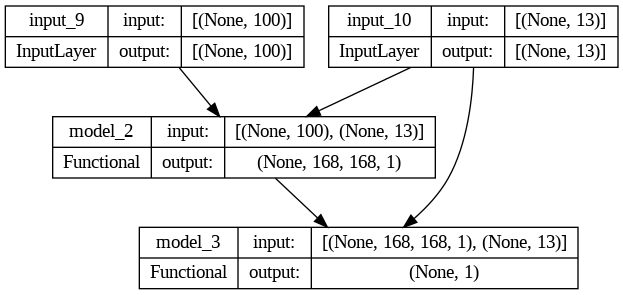

In [ ]:
utils.plot_model(build_cgan(build_cgan_generator(z_dim), build_cgan_discriminator(img_shape)), show_shapes=True)

In [ ]:
# Build and compile the Discriminator
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.0001),
                      metrics=['accuracy'])

# Build the Generator
generator = build_cgan_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile CGAN model with fixed Discriminator to train the Generator
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001))

## Training

In [ ]:
accuracies = []
losses = []


def train(iterations, batch_size, sample_interval, X_train, y_train):

    # Load the MNIST dataset
    #(X_train, y_train), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    #X_train = X_train / 127.5 - 1.
    #X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images and their labels
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels], verbose=0)

        # Train the Discriminator
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of noise vectors
        z = np.random.normal(0, 1, (batch_size, z_dim))

        # Get a batch of random labels
        #labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        labels = np.random.random((batch_size,dims_meta))
        labels = (labels-0.5)*2

        # Train the Generator
        g_loss = cgan.train_on_batch([z, labels], real)

        if (iteration + 1) % sample_interval == 0:
            # Save the generator model in Keras' native format
            model_save_path = f'./weights_168x168/CGAN_model_{iteration + 1}.keras'
            generator.save(model_save_path)


            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            # Output sample of generated images
            sample_images()

In [ ]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    #labels = np.arange(0, 10).reshape(-1, 1)
    labels = np.random.random((10,dims_meta))
    labels = (labels-0.5)*2

    # Generate images from random noise
    gen_imgs = generator.predict([z, labels], verbose=0)

    # Rescale image pixel values to [0, 1]
    #gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):

            # First, squeeze to remove the channel dimension
            image = gen_imgs[cnt, :, :, 0].squeeze()

            # Resize image to be square (100x100) using OpenCV
            resized_image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)

            # Output a grid of images
            axs[i, j].imshow(resized_image, cmap='gray')
            axs[i, j].axis('off')
            #axs[i, j].set_title("Digit: %d" % labels[cnt])
            axs[i, j].set_title(list(np.round(labels[cnt],2)))  ## NEW
            cnt += 1

    plt.show()

# Train the Model and Inspect Training Progress

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

In [ ]:
iterations = 20000 #8000
batch_size = 32
sample_interval = 1000

# Train the CGAN for the specified number of iterations
train(iterations, batch_size, sample_interval, X_train, y_train)

Output hidden; open in https://colab.research.google.com to view.

# Output from a Trained CGAN Model

In [ ]:
# Set grid dimensions
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Get image labels to generate: 5 samples for each label
#labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
#labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)
#labels_to_generate = np.random.random((image_grid_rows*image_grid_columns,dims_meta))
#labels_to_generate = (labels_to_generate-0.5)*2
labels_to_generate = y_test[:50,:]

# Generate images from random noise
gen_imgs = generator.predict([z, labels_to_generate], verbose=0)

# Rescale image pixel values to [0, 1]
#gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output a grid of images
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(list(np.round(labels_to_generate[cnt],2)))  ## NEW
        cnt += 1

In [ ]:
# Set grid dimensions
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Get image labels to generate: 5 samples for each label
#labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
#labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)
#labels_to_generate = np.random.random((image_grid_rows*image_grid_columns,dims_meta))
#labels_to_generate = (labels_to_generate-0.5)*2
labels_to_generate = y_test[:50,:]

# Generate images from random noise
gen_imgs = X_test[:50,:,:,:]

# Rescale image pixel values to [0, 1]
#gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output a grid of images
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(list(np.round(labels_to_generate[cnt],2)))  ## NEW
        cnt += 1